# Heart Sound segmentation

In [29]:
import wave
import numpy as np
from scipy import signal
from pylab import *
%matplotlib inline
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
import struct
import scipy
import scipy.io as sio
import scipy.signal
#!pip install PyWavelets
import pywt
from scipy.stats import multivariate_normal

In [30]:
def audioread(FNAME):
    print FNAME
    f = wave.open(FNAME)

    # frames will hold the bytestring representing all the audio frames
    frames = f.readframes(-1)
    PCG = struct.unpack('h'*f.getnframes(), frames)
    PCG = np.array(PCG)
    # normalize between -1 and +1
    PCG = PCG*1.0/max(abs(PCG))
    sig_fs=f.getframerate()
    t = [float(i)/sig_fs for i in range(len(PCG))]
    return PCG, t, sig_fs

In [31]:
def sigResample(orgSignal, curFreq, newFreq):
    new_length= len(orgSignal)*newFreq/curFreq
    downsampled_sig = signal.resample(orgSignal, new_length)
    return downsampled_sig

In [32]:
def sigResize(orgSignal, new_length):
    resized_sig = signal.resample(orgSignal, new_length)
    return resized_sig

In [33]:
def sigNormalize(signal):
    mean_of_signal = mean(signal)
    standard_deviation = std(signal)
    normalised_signal = (signal - mean_of_signal)/standard_deviation
    return normalised_signal

# Feature extraction
#### Extract the features from the training set of recordings (getSpringerPCGFeatures.m). These include the:
- Homomorphic envelope
- Hilbert envelope
- Power spectral density envelope
- Discrete wavelet transform envelope

In [34]:
def sigFilter(signal, order, cutoff, fs, btype):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    if btype == 'low':
        b, a = butter(order, normal_cutoff, btype='low')
    elif btype == 'high':
        b, a = butter(order, normal_cutoff, btype='high', analog=False)
    filtered_sig = scipy.signal.filtfilt(b, a, signal)
    return filtered_sig

### Spike removal
removes the spikes in a signal as done by Schmidt et al in

In [35]:
def SpikeRemoval(original_signal, windowsize):
    # Find any samples outside of a integer number of windows:
    trailingsamples = int(mod(len(original_signal), windowsize))
    # Reshape the signal into a number of windows:
    sampleframes = reshape( original_signal[0:-trailingsamples],(-1, windowsize))
    # Find the MAAs:
    MAAs = np.amax(abs(sampleframes), axis=1)
    # While there are still samples greater than 3* the median value of the
    # MAAs, then remove those spikes:
    while(any(MAAs > median(MAAs)*3)):

        #Find the window with the max MAA:
        window_num= np.argmax(MAAs)
        val = np.max(MAAs)


        # Find the postion of the spike within that window:
        spike_position = np.argmax(abs(sampleframes[window_num,:]))

        # Finding zero crossings (where there may not be actual 0 values, just a change from positive to negative):
        zero_crossings = [abs(diff(sign(sampleframes[window_num,:])))]
        zero_crossings=np.append(np.array([2]),zero_crossings)
        if (spike_position==0): 
            spike_start=0
        else:
            befor_spike= zero_crossings[0:spike_position]
            b = befor_spike[::-1]
            spike_start = len(b) - np.argmax(b) - 1
        #print spike_start
        #Find the end of the spike, finding the first zero crossing after
        #spike position. If that is empty, take the end of the window:
        zero_crossings[0:spike_position] = 0
        if np.argmax(zero_crossings)==0: #no zero cross after spike
            spike_end=len(zero_crossings)-1
        else:
            spike_end=np.argmax(zero_crossings)
        #print spike_end

        #Set to Zero
        sampleframes[window_num, spike_start:spike_end] = 0.0001
        #Recaclulate MAAs
        MAAs = np.amax(abs(sampleframes), axis=1)
    despiked_signal = reshape(sampleframes, (-1,)) 
    # Add the trailing samples back to the signal:
    despiked_signal = np.append(despiked_signal, original_signal[-trailingsamples:])
    return despiked_signal

### 3.1. homomorphic envelope

In [36]:
def homomorphicEnvelope(input_signal, sampling_frequency, lpf_frequency = 8.0):
    #8Hz, 1st order, Butterworth LPF
    B_low,A_low = signal.butter(1,2*lpf_frequency/sampling_frequency, btype='low');
    #print B_low
    #print A_low
    #b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    a= log(abs(signal.hilbert(input_signal)))
    c=signal.filtfilt(B_low,A_low,a, padlen=4)
    homomorphic_envelope = exp(c);
    homomorphic_envelope[0] = homomorphic_envelope[1]
    return homomorphic_envelope

### 3.2. Hilbert Envelope
This function finds the Hilbert envelope of a signal. Extract the envelope, which is the magnitude (modulus) of the analytic signal. The Hilbert transform is useful in calculating instantaneous attributes of a time series, especially the amplitude and frequency. The instantaneous amplitude is the amplitude of the complex Hilbert transform; the instantaneous frequency is the time rate of change of the instantaneous phase angle

In [37]:
def hilbertEnvelope(input_signal):
    hilbert_envelope =  abs(scipy.signal.hilbert(input_signal)) #find the envelope of the signal using the Hilbert transform
    return hilbert_envelope

### 3.3. Power Spectral Density (PSD) feature
PSD-based feature extraction for heart sound segmentation.  

In [38]:
def PSD(input_signal, sampling_frequency):    
    noverlap = round(sampling_frequency/80)
    NFFT = 1000 #  frequency resolution: Length of the FFT used (frequencies), if a zero padded FFT
    nperseg = sampling_frequency/40  #Length of each time segment (the length of the windowing segments). 
    F, t, Sxx =scipy.signal.spectrogram(x=input_signal, fs=sampling_frequency, noverlap=noverlap, nfft=NFFT , nperseg=nperseg)
    frequency_limit_low = 40
    frequency_limit_high = 60
    low_limit_position = argmin(abs(F - frequency_limit_low))
    high_limit_position = argmin(abs(F - frequency_limit_high))
    # Find the mean PSD over the frequency range of interest:
    psd = mean(Sxx[low_limit_position:high_limit_position,:],axis=0);
    return psd

### 3.4. Wavelet features

In [39]:
def waveletFeature(signal,wavelet_name, wavelet_level):
    coeffs = pywt.wavedec(signal, wavelet_name,level= wavelet_level)
    wavelet_feature = abs(coeffs[-wavelet_level])
    return wavelet_feature

# All features together

In [40]:
def extractFeatures(PCG_resampled, fs , featuresFs):
    ## signal filtering
    low_passed_PCG = sigFilter(PCG_resampled, 8, 400, fs, 'low')
    high_passed_PCG = sigFilter(low_passed_PCG, 4, 25, fs, 'high')

    despiked_signal = SpikeRemoval(high_passed_PCG, windowsize = int(round(fs/2)))

    # homomorphic
    homomorphic_envelope = homomorphicEnvelope(despiked_signal,fs)
    downsampled_homomorphic_envelope = sigResample(homomorphic_envelope, fs, featuresFs)
    downsampled_homomorphic_envelope = sigNormalize(signal=downsampled_homomorphic_envelope)
    downsampled_sig_len = len(downsampled_homomorphic_envelope)

    # hilbert
    hilbert_envelope = hilbertEnvelope(input_signal = despiked_signal)
    downsampled_hilbert_envelope = sigResample(hilbert_envelope, fs, featuresFs)
    downsampled_hilbert_envelope = sigNormalize(downsampled_hilbert_envelope)

    # PSD
    psd = PSD(despiked_signal,fs)
    psd = sigResize(psd,downsampled_sig_len) 
    psd = sigNormalize(psd)


    #wavelet
    wavelet_feature = waveletFeature(despiked_signal,'rbio3.9', 3)
    downsampled_wavelet= scipy.signal.resample(wavelet_feature, downsampled_sig_len)
    downsampled_wavelet = sigNormalize(downsampled_wavelet)
    

    PCG_Features = np.column_stack((downsampled_homomorphic_envelope, downsampled_hilbert_envelope, psd, downsampled_wavelet))
    return PCG_Features




# Get Heart Rate Schmidt

In [41]:
def HeartRateSchmidt(sig,fs):
    low_passed_PCG = sigFilter(sig, 2, 400, fs, 'low')
    high_passed_PCG = sigFilter(low_passed_PCG, 2, 25, fs, 'high')
    despiked_signal = SpikeRemoval(high_passed_PCG, windowsize = int(round(fs/2)))
    homomorphic_envelope = homomorphicEnvelope(despiked_signal,fs)
    y = homomorphic_envelope-mean(homomorphic_envelope)
    corr = correlate(y, y, mode='full')
    corr = corr*1.0 / corr[corr.argmax()]
    signal_autocorrelation = corr[len(y)-1:]
    min_index = int(0.5*fs)
    max_index = 2*fs
    aindex = argmax(signal_autocorrelation[min_index:max_index]) #maximum between max and min range
    true_index = aindex + min_index #-1 #maximum point
    heartRate = 60/(true_index*1.0/fs)
    return signal_autocorrelation, heartRate

### Find the systolic time interval

In [42]:
def getSystolicTimeInterval(signal_autocorrelation,heartRate,fs):
    max_sys_duration = int(round(((60/heartRate)*fs)/2))
    min_sys_duration = int(round(0.2*fs))
    pos = argmax(signal_autocorrelation[min_sys_duration:max_sys_duration])
    systolicTimeInterval = (min_sys_duration+pos)*1.0/fs
    return systolicTimeInterval

# Using viterbi to Decode PCG

The observation __probability density distribution__ $B={b_j(O_t)}$ defines the probability that state ‘j ’ generates the output $O_t$. 

In [43]:
#When saving the coefficients from the logistic regression, it orders them P(class 1) then P(class 2). When
#training, I label the classes as 0 and 1, so the
# correct probability would be pihat(2).
def mnrval(B,obs):
    logit = B[0]+ np.dot(obs, B[1:].reshape(4,))
    p = np.exp(logit)/(1+np.exp(logit))
    pihat = np.column_stack((1-p,p))
    return pihat

In [44]:
def get_duration_distributions(observation_sequence, B_matrix, total_obs_distribution, pi_vector,heartRate, systolic_time , audio_segmentation_Fs):
    T = observation_sequence.shape[0]
    N = observation_sequence.shape[1] # Number of states
    observation_probs = np.zeros((T,N)) #Probablity of an observation P(obs)
    for n in range(N):
        # MLR gives P(state|obs)
        # Therefore, need Bayes to get P(o|state)
        # P(o|state) = P(state|obs) * P(obs) / P(states)
        # Where p(obs) is derived from a MVN distribution from all obserbations, and p(states) is taken from the pi_vector:
        pihat = mnrval(B_matrix[n],observation_sequence)
        for t in range(T):
            Po_correction = multivariate_normal.pdf(observation_sequence[t,], mean=total_obs_distribution[0][0][0],cov=total_obs_distribution[1][0])
            observation_probs[t,n] = (pihat[t,0]*Po_correction)/pi_vector[n]
    mean_S1 = round(0.122*audio_segmentation_Fs);
    std_S1 = round(0.022*audio_segmentation_Fs);
    mean_S2 = round(0.094*audio_segmentation_Fs);
    std_S2 = round(0.022*audio_segmentation_Fs);
    mean_systole = round(systolic_time*audio_segmentation_Fs) - mean_S1;
    std_systole = (25.0/1000)*audio_segmentation_Fs;
    mean_diastole = ((60.0/heartRate) - systolic_time - 0.094)*audio_segmentation_Fs;
    std_diastole = 0.07*mean_diastole + (6.0/1000)*audio_segmentation_Fs;
    # d_distributions is a 4 (the number of states) dimensional vector of gaussian mixture models (one dimensional in this case), representing the mean and std deviation of the duration in each state.
    #array for the mean and covariance of the duration distributions:
    d_distributions = np.zeros((4,2))

    # Assign mean and covariance values to d_distributions:
    d_distributions[0,0] = mean_S1;
    d_distributions[0,1] = std_S1**2;

    d_distributions[1,0] = mean_systole;
    d_distributions[1,1] = std_systole**2;

    d_distributions[2,0] = mean_S2;
    d_distributions[2,1] = std_S2**2;

    d_distributions[3,0] = mean_diastole;
    d_distributions[3,1] = std_diastole**2;

    #Min /Max systole and diastole times
    min_systole = mean_systole - 3*(std_systole+std_S1);
    max_systole = mean_systole + 3*(std_systole+std_S1);

    min_diastole = mean_diastole-3*std_diastole;
    max_diastole = mean_diastole + 3*std_diastole;

    #Setting the Min and Max values for the S1 and S2 sounds:
    #If the minimum lengths are less than a 50th of the sampling frequency, set to a 50th of the sampling frequency:
    min_S1 = (mean_S1 - 3*(std_S1))
    if(min_S1<(audio_segmentation_Fs/50)):
        min_S1 = (audio_segmentation_Fs/50)


    min_S2 = (mean_S2 - 3*(std_S2))
    if(min_S2<(audio_segmentation_Fs/50)):
        min_S2 = (audio_segmentation_Fs/50)

    max_S1 = (mean_S1 + 3*(std_S1))
    max_S2 = (mean_S2 + 3*(std_S2))


    duration_probs = np.zeros((N,3*audio_segmentation_Fs))
    duration_sum = np.zeros((N,1))

    # Setting the maximum duration of a single state. This is set to an entire heart cycle:
    max_duration_D = round((1*(60/heartRate))*audio_segmentation_Fs);

    # Now we calculate duration density pj(d):
    # d is the state duration and pj(d) is the probability density function of the d for state j
    realmin = 2**-149 
    for state_j in range(N):
        for d in range(int(max_duration_D)):
            dur = d*1.0
            if(state_j == 0):
                duration_probs[state_j,d] = multivariate_normal.pdf(dur, mean=d_distributions[state_j,0],cov=d_distributions[state_j,1])
                if(dur < min_S1 or dur > max_S1):
                    duration_probs[state_j,d]= realmin

            elif(state_j==2):
                duration_probs[state_j,d] = multivariate_normal.pdf(dur, mean=d_distributions[state_j,0],cov=d_distributions[state_j,1])
                if(dur < min_S2 or dur > max_S2):
                    duration_probs[state_j,d]= realmin

            elif(state_j==1):
                duration_probs[state_j,d] = multivariate_normal.pdf(dur, mean=d_distributions[state_j,0],cov=d_distributions[state_j,1])
                if(d < min_systole or d > max_systole):
                    duration_probs[state_j,d]= realmin

            elif (state_j==3):
                duration_probs[state_j,d] = multivariate_normal.pdf(dur, mean=d_distributions[state_j,0],cov=d_distributions[state_j,1])
                if(d < min_diastole or d > max_diastole):
                    duration_probs[state_j,d]= realmin

        duration_sum[state_j] = sum(duration_probs[state_j,:])  

    if(duration_probs.shape[1]>3*audio_segmentation_Fs):
            #duration_probs(:,(3*):end) = []
            print "warning !"

    return duration_probs, duration_sum , observation_probs, max_duration_D

## Perform the actual Viterbi Recursion to calculte delta_t(j)

In [45]:
def viterbi(max_duration_D, pi_vector, observation_probs, duration_probs, duration_sum):
    realmin = 2**-149 
    T = observation_probs.shape[0]
    N = observation_probs.shape[1] # Number of states
    
    delta = np.ones((int(T + max_duration_D),N))*-inf  #444+25-1 x 4
    
    #first value is the probability of intially being in each state * probability of first observation coming from each state
    delta[0,:] = log(pi_vector) + log(observation_probs[0,:] )
    
    # psi is the argument that maximises the transition between states (this is basically the previous state that had the highest transition probability to the current state) is tracked using the psi variable.
    psi = np.zeros((T+ int(max_duration_D),N),dtype=int)  #444+25 x 4
    psi[0,:] = -1  #Equation 32b
    
    
    # An additional variable, that is not included on page 264 or Rabiner, is the state duration that maximises the delta variable. This is essential for the duration dependant HMM.
    psi_duration =np.zeros((T + int(max_duration_D),N),dtype=int)
    
    # The state transition matrix A = {aij } defines the probability of transition from state ‘i’ to state ‘j’ between t and t + 1
    a_matrix = np.array( [[0,1,0,0],[0, 0 ,1 ,0],[ 0, 0, 0 ,1],[1, 0 ,0 ,0]])
    
    
    
    # viterbi
    # for each observation
    for t in range(1, T+int(max_duration_D)):  #1-20-468, length of observations
        for j in range(N): # for each states (4 states)
            for d in range(1, int(max_duration_D)+1):  # observations from the last transition, from i to j, ( last observations 1-to-25 )
                # Define the window from [t-d, t]
                start_t = t - d
                if(start_t<0):
                    start_t = 0

                if(start_t > T):
                    start_t = T

                end_t = t
                if(t>T):
                    end_t = T
                #print (t,j,d,start_t,end_t, max_delta)

                # We need to calculte 3 things for each window:
                # 1) probability of transitioning from the last state i to the state of this window j, at start_t
                # 2) the probablity of staying in state j for d duration 
                # 3) Find the probabilities of the observations over the analysis window

                # 1) Find the max_delta and index of that from the previous step and the transition to the current step:
                # This is the first half of the expression of equation 33a from Rabiner: δt−d(i)aij
                # max_index shows the state before(or at?) start_t
                tmp = delta[start_t,:]+log(a_matrix[:,j])
                max_index=np.argmax(tmp)
                max_delta=tmp[max_index]
                #print (t,j,d,start_t,end_t, max_delta)

                # 2)the probablity of staying in state j for d duration 
                pjd = log((duration_probs[j,d-1]/duration_sum[j]))


                # 3) calculation of the probability of observing all the observations from time t − d to time t in state j.
                # prod($b_j(O_{t−s})$) is the probablity of being in state j and observing $O_{t-d}$, ...,  $O_{t-1}$, $O_t$, that is, the probability that state j generates the output observed in the period t − d to t
                # Find the normalised probabilities of the observations over the analysis window:
                probs = np.prod(observation_probs[start_t:end_t,j])

                # Find the normalised probabilities of the observations 
                # at only the time point at the start of the time window:
                if(probs ==0):
                    probs = realmin;
                emission_probs = np.log(probs)            


                # Keep a running total of the emmission probabilities as the
                # start point of the time window is moved back one step at a
                # time. This is the probability of seeing all the observations
                # in the analysis window in state j:
                if(emission_probs == 0 or np.isnan(emission_probs)):
                    emission_probs =realmin



                # Find the total probability of transitioning from the last
                # state to this one, with the observations and being in the same
                # state for the analysis window. This is the duration-dependant
                # variation of equation 33a from Rabiner:
                delta_temp = max_delta + emission_probs + pjd

                if(delta_temp > delta[t,j]):
                    delta[t,j] = delta_temp
                    psi[t,j] = max_index
                    psi_duration[t,j] = d
                    
                    
                    
    ################ Forward - find qt ############### 
    temp_delta = delta[T:,:]
    # Find the maximum value in this section, and which state it is in:
    pos = np.unravel_index(temp_delta.argmax(), temp_delta.shape)
    # Change this position to the real position in delta matrix:
    pos = pos[0] + T
    # 1. finds P*, the most likely last state in the sequence
    state = np.argmax(delta[pos,:])
    # 2. finds the state that precedes the last most likely state
    offset = pos
    preceding_state = psi[offset,state]
    # 3. finds the onset in time of the last state
    onset = int( offset - psi_duration[offset,state])
    # 4. sets the most likely last state to the q_t variable
    qt = np.zeros(len(delta))-1
    qt[onset:offset] = state
    # The state is then updated to the preceding state, found above, which must end when the last most likely state started in the observation sequence:
    state = int(preceding_state)
    count = 0
    # While the onset of the state is larger than the maximum duration specified:
    while(onset > 2):

        #2
        offset = onset
        preceding_state = psi[offset,state]



        #3
        onset = offset - psi_duration[offset,int(state)];

        #4
        #offset_array[onset:offset,3] = state;

        if(onset<2):
            onset = 1

        qt[onset:offset] = state;
        state = preceding_state;
        count = count +1;

        if(count> 1000):
            break;
    qt = qt[0:T]
    return  psi, psi_duration, delta,qt                           

## Extend qt

In [46]:
def extend_qt(original_qt, new_length, old_fs, new_fs):
    expanded_qt = np.zeros(new_length)
    indeces_of_changes = nonzero(np.diff(original_qt))[0]
    indeces_of_changes = np.append(indeces_of_changes,len(original_qt))
    start_index = 1
    end_index = indeces_of_changes[start_index]+1
    mid_point = round((end_index - start_index)/2) + start_index
    mid_point
    start_index = 0;
    for i in range(len(indeces_of_changes)):

        end_index = indeces_of_changes[i]+1

        mid_point = int( round((end_index - start_index)/2) + start_index)

        value_at_mid_point = original_qt[mid_point]

        expanded_start_index = int(round((start_index*1.0/old_fs)*new_fs) )
        expanded_end_index = int(round((end_index*1.0/(old_fs))*new_fs))

        if(expanded_end_index > new_length):
            expanded_end_index = int(new_length)


        expanded_qt[expanded_start_index:expanded_end_index] = value_at_mid_point

        start_index = end_index
    return expanded_qt

## Feature set

In [47]:
def get_segments(B_matrix, total_obs_distribution, pi_vector, file_name, fs = 1000,  featuresFs =50):
    
    PCG, t, org_fs = audioread(file_name)


    ## resample audio
    PCG_resampled = sigResample(PCG, org_fs, fs)
    PCG_resampled=PCG_resampled[:-1]  #why ??


    ## downsample and normalize signal
    downsampled_PCG = sigResample(PCG_resampled, fs, featuresFs)
    downsampled_PCG = sigNormalize(downsampled_PCG)

    # extract featurs
    PCG_Features = extractFeatures(PCG_resampled, fs , featuresFs)

    ## find hear rate and systolic time interval
    signal_autocorrelation ,heartRate = HeartRateSchmidt(PCG_resampled,fs)
    systolicTimeInterval = getSystolicTimeInterval(signal_autocorrelation,heartRate,fs)


    duration_probs, duration_sum, observation_probs, max_duration_D = get_duration_distributions(PCG_Features, B_matrix, total_obs_distribution, pi_vector, heartRate, systolicTimeInterval, featuresFs)

    psi, psi_duration, delta, qt = viterbi( max_duration_D, pi_vector, observation_probs, duration_probs, duration_sum)

    expanded_qt = extend_qt(qt, len(PCG_resampled), featuresFs, fs)
    return expanded_qt, PCG_resampled

In [48]:
def extractFeaturesFromHsIntervals(assigned_states, PCG):

    indx = find(abs(diff(assigned_states))>0) # find the locations with changed states

    if assigned_states[0] > -1:   # for some recordings, there are state zeros at the beginning of assigned_states
        if assigned_states [0] == 3:
                K=0
        elif assigned_states [0] == 2:
                K=1
        elif assigned_states [0] == 1:
                K=2
        elif assigned_states [0] == 0:
                K=3
    else:
        if assigned_states[indx[0]+1] == 3:
            K=1
        elif assigned_states[indx[0]+1] == 2:
            K=2
        elif assigned_states[indx[0]+1] == 1:
            K=3
        elif assigned_states[indx[0]+1] == 0:
            K=0
            
    #print([assigned_states[indx[K]+1],assigned_states[indx[K+1]+1],assigned_states[indx[K+2]+1],assigned_states[indx[K+3]+1]])
    
    indx2 = indx[K:]
    rem  = mod(len(indx2),4)
    indx2 = indx2[:len(indx2)-rem]
    A = np.array(indx2).reshape(-1,4)+1 ## TO DO: should I add +1
    
    
    # Feature calculation
    m_RR        = round(mean(diff(A[:,0])));             # mean value of RR intervals
    sd_RR       = round(std(diff(A[:,0])));              # standard deviation (SD) value of RR intervals
    mean_IntS1  = round(mean(A[:,1]-A[:,0]));            # mean value of S1 intervals
    sd_IntS1    = round(std(A[:,1]-A[:,0]));             # SD value of S1 intervals
    mean_IntS2  = round(mean(A[:,3]-A[:,2]));            # mean value of S2 intervals
    sd_IntS2    = round(std(A[:,3]-A[:,2]));             # SD value of S2 intervals
    mean_IntSys = round(mean(A[:,2]-A[:,1]));            # mean value of systole intervals
    sd_IntSys   = round(std(A[:,2]-A[:,1]));             # SD value of systole intervals
    mean_IntDia = round(mean(A[1:,0]-A[0:-1,3]));  # mean value of diastole intervals
    sd_IntDia   = round(std(A[1:,0]-A[0:-1,3]));   # SD value of diastole intervals
    
    l = A.shape[0]-1
    R_SysRR = np.zeros(l)
    R_DiaRR = np.zeros(l)
    R_SysDia = np.zeros(l)
    P_S1 = np.zeros(l)
    P_Sys = np.zeros(l)
    P_S2 = np.zeros(l)
    P_Dia = np.zeros(l)
    P_SysS1 = np.zeros(l)
    P_DiaS2 = np.zeros(l)
    for i in range(l):
        R_SysRR[i]  = 1.0*(A[i,2]-A[i,1])/(A[i+1,0]-A[i,0])*100
        R_DiaRR[i]  = 1.0*(A[i+1,0]-A[i,3])/(A[i+1,0]-A[i,0])*100
        R_SysDia[i] =  R_SysRR[i]/R_DiaRR[i]*100

        P_S1[i]     = sum(abs(PCG[A[i,0]:A[i,1]]))*1.0/(A[i,1]-A[i,0]);
        P_Sys[i]    = sum(abs(PCG[A[i,1]:A[i,2]]))*1.0/(A[i,2]-A[i,1]);
        P_S2[i]     = sum(abs(PCG[A[i,2]:A[i,3]]))*1.0/(A[i,3]-A[i,2]);
        P_Dia[i]    = sum(abs(PCG[A[i,3]:A[i+1,0]]))*1.0/(A[i+1,0]-A[i,3]);
        if P_S1[i]>0:
            P_SysS1[i] = P_Sys[i]*1.0/P_S1[i]*100;
        else:
            P_SysS1[i] = 0;
        
        if P_S2[i]>0:
            P_DiaS2[i] = P_Dia[i]*1.0/P_S2[i]*100;
        else:
            P_DiaS2[i] = 0;

    m_Ratio_SysRR   = np.mean(R_SysRR);  # mean value of the interval ratios between systole and RR in each heart beat
    sd_Ratio_SysRR  = np.std(R_SysRR);   # SD value of the interval ratios between systole and RR in each heart beat
    m_Ratio_DiaRR   = np.mean(R_DiaRR);  # mean value of the interval ratios between diastole and RR in each heart beat
    sd_Ratio_DiaRR  = np.std(R_DiaRR);   # SD value of the interval ratios between diastole and RR in each heart beat
    m_Ratio_SysDia  = np.mean(R_SysDia); # mean value of the interval ratios between systole and diastole in each heart beat
    sd_Ratio_SysDia = np.std(R_SysDia);  # SD value of the interval ratios between systole and diastole in each heart beat

    
    indx_sys = find((P_SysS1>0) & (P_SysS1<100));   # avoid the flat line signal
    if len(indx_sys)>1:
        m_Amp_SysS1  = mean(P_SysS1[indx_sys]); # mean value of the mean absolute amplitude ratios between systole period and S1 period in each heart beat
        sd_Amp_SysS1 = std(P_SysS1[indx_sys]);  # SD value of the mean absolute amplitude ratios between systole period and S1 period in each heart beat
    else:
        m_Amp_SysS1  = 0
        sd_Amp_SysS1 = 0
    
    indx_dia = find((P_DiaS2>0) & (P_DiaS2<100))
    if len(indx_dia)>1:
        m_Amp_DiaS2  = mean(P_DiaS2[indx_dia]); # mean value of the mean absolute amplitude ratios between diastole period and S2 period in each heart beat
        sd_Amp_DiaS2 = std(P_DiaS2[indx_dia]);  # SD value of the mean absolute amplitude ratios between diastole period and S2 period in each heart beat
    else:
        m_Amp_DiaS2  = 0
        sd_Amp_DiaS2 = 0
    
    
    features = [m_RR, sd_RR,  mean_IntS1, sd_IntS1,  mean_IntS2, sd_IntS2,  mean_IntSys, sd_IntSys,  mean_IntDia, sd_IntDia, \
                m_Ratio_SysRR, sd_Ratio_SysRR, m_Ratio_DiaRR, sd_Ratio_DiaRR, m_Ratio_SysDia, sd_Ratio_SysDia, \
                m_Amp_SysS1, sd_Amp_SysS1, m_Amp_DiaS2, sd_Amp_DiaS2]
    return features





In [49]:
def  classifyFromHsIntervals(features):
    # 1 for abnormal recording
    # -1 for normal recording
    # 0 for unsure recording (too noisy)
    B = [-4.55969671153671,-0.0190844674392002,-0.00365674916123946,0.0464309139962342,0.0382411423829992,-0.0144478229473877,0.0169187704188220,0.0182152301056541,0.0166856367355031,0.0242221034823620,-0.0124936707725577,0.121391485490513,0.228393275829136,-0.0379380232270407,0.407767267634115,-0.0335230435994371,0.0834749593084066,-0.0118791358148168,0.0191288105549299,0.00948554070687907,0.0502122854641683]
    x = np.dot( features, B[1:])+B[0]
    predictor = 1.0 / (1 + math.exp(-x))
    #predictor = glmval(B,features,'logit');
    thr  = 0.5; # classification threshold, thr>0.5 for abnormal recordings.
    if predictor > thr:
        classifyResult = 1;
    else:
        classifyResult = -1;
    return classifyResult

In [50]:
def show_graph(PCG_resampled, expanded_qt):
    normalised_signal = sigNormalize(PCG_resampled)
    plt.rcParams['figure.figsize'] = (14, 10)
    fr = 0
    to =2000
    y1 = normalised_signal[fr:to]
    y2 = expanded_qt[fr:to]
    #t = [float(i)/fs for i in range(len(y1))]
    plt.plot( y1, 'g-', linewidth=0.5 ,label='data')
    plt.plot( y2, 'r-', linewidth=1, label='stage')
    plt.xlabel('Time [sec]')
    plt.grid()
    plt.legend()
    plt.subplots_adjust(hspace=0.35)
    plt.show()

### local classification

In [51]:
def classify_local(file_name, B_matrix, total_obs_distribution, pi_vector):
    expanded_qt, PCG_resampled = get_segments(B_matrix, total_obs_distribution, pi_vector, file_name)
    features =  extractFeaturesFromHsIntervals(expanded_qt, PCG_resampled)
    return classifyFromHsIntervals(features)

## Download data and parameters

In [52]:
!mkdir heartsound
!wget --output-document heartsound/training.zip  https://physionet.org/physiobank/database/challenge/2016/training.zip
!unzip -o heartsound/training.zip -d heartsound/

mkdir: cannot create directory ‘heartsound’: File exists
--2017-05-31 12:56:11--  https://physionet.org/physiobank/database/challenge/2016/training.zip
Resolving physionet.org (physionet.org)... 128.30.30.88
Connecting to physionet.org (physionet.org)|128.30.30.88|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190112103 (181M) [application/zip]
Saving to: ‘heartsound/training.zip’

100%[======================================>] 190,112,103 35.4MB/s   in 5.4s   

2017-05-31 12:56:17 (33.3 MB/s) - ‘heartsound/training.zip’ saved [190112103/190112103]

Archive:  heartsound/training.zip
  inflating: heartsound/training-a/a0307.wav  
  inflating: heartsound/training-a/a0356.dat  
  inflating: heartsound/training-a/a0291.hea  
  inflating: heartsound/training-a/a0130.dat  
  inflating: heartsound/training-a/a0076.hea  
  inflating: heartsound/training-a/a0183.dat  
  inflating: heartsound/training-a/a0318.hea  
  inflating: heartsound/training-a/a0046.wav  
  inflat

In [53]:
#!wget --output-document heartsound/Springer_Parameters.zip https://ibm.box.com/shared/static/ly0ejof5h1s1zhtxqoj28jgy8cwdr80j.zip
#!unzip -o heartsound/Springer_Parameters.zip -d heartsound/  

In [54]:
# pre-trained Parameters
mat_contents = sio.loadmat('heartsound/Springer_Parameters/Springer_B_matrix.mat')
B_matrix = mat_contents['Springer_B_matrix'][0]
mat_contents = sio.loadmat('heartsound/Springer_Parameters/Springer_total_obs_distribution.mat')
total_obs_distribution= mat_contents['Springer_total_obs_distribution']
mat_contents = sio.loadmat('heartsound/Springer_Parameters/Springer_pi_vector.mat')
pi_vector= mat_contents['Springer_pi_vector'][0]

heartsound/training-a/a0245.wav
heartsound/training-a/a0245.wav


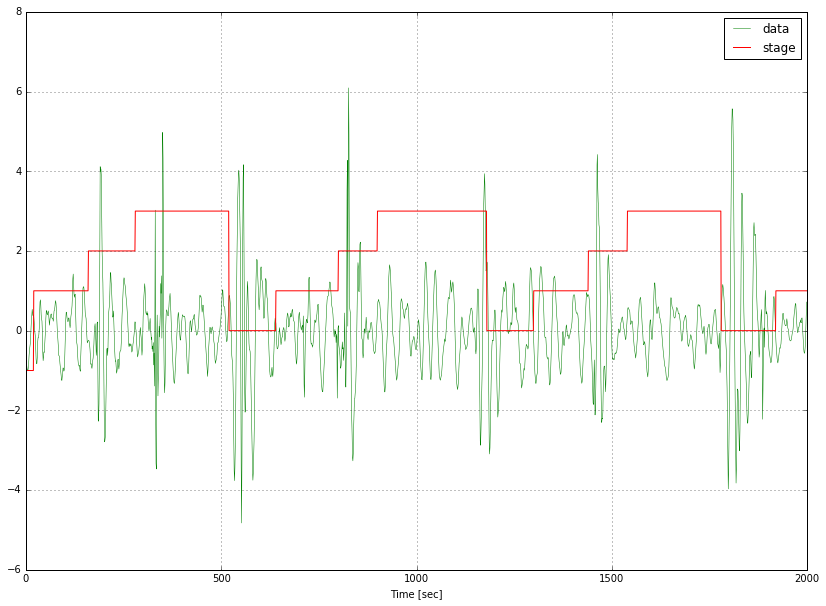

-1


In [55]:
## Test
## 0:S1, 1:systole, 2:S2  3:diastole 
for file_name in ['heartsound/training-a/a0245.wav']:
    print file_name
    expanded_qt, PCG_resampled = get_segments(B_matrix, total_obs_distribution, pi_vector, file_name)
    show_graph(PCG_resampled, expanded_qt)
    features =  extractFeaturesFromHsIntervals(expanded_qt, PCG_resampled)
    print classifyFromHsIntervals(features)

In [56]:
import os
direc = "heartsound/training-a/"
fileList=[]
for file in os.listdir(direc):
    if file.endswith(".wav"):
        fileList.append(os.path.join(direc, file))

This code is python implimentation of Springer, et al.  

References:
    
1. Springer, David B., Lionel Tarassenko, and Gari D. Clifford. "Logistic regression-hsmm-based heart sound segmentation." IEEE Transactions on Biomedical Engineering 63.4 (2016): 822-832.   https://github.com/davidspringer/Springer-Segmentation-Code

2. Rabiner, Lawrence R. "A tutorial on hidden Markov models and selected applications in speech recognition." Proceedings of the IEEE 77.2 (1989): 257-286.

3. Schmidt, S. E., et al. "Segmentation of heart sound recordings by a duration-dependent hidden Markov model." Physiological measurement 31.4 (2010): 513.